# Keras implementation of a sequence to sequence model for time series prediction using an encoder-decoder architecture.

I created this post to share a flexible and reusable implementation of a sequence to sequence model using Keras.

I drew inspiration from two other posts:
* ["Sequence to Sequence (seq2seq) Recurrent Neural Network (RNN) for Time Series Prediction"](https://github.com/guillaume-chevalier/seq2seq-signal-prediction) by Guillaume Chevalier.
* ["A ten-minute introduction to sequence-to-sequence learning in Keras"](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) by François Chollet.

I strongly recommend visiting Guillaume's repository for some great projects.  
François Chollet is the primary author and currently the maintainer of Keras. His post presents an implementation of a seq2seq model for machine translation.

## Context
Time series prediction is a widespread problem. Applications range from price and weather forecasting to biological signal prediction.

This post describes how to implement a Recurrent Neural Network (RNN) encoder-decoder for time series prediction using Keras. I will focus on the practical aspects of the implementation, rather than the theory underlying neural networks, though I will try to share some of the reasoning behind the ideas I present. I assume a basic understanding of how RNNs work. If you need to catch up, a good place to start is the classic ["Understanding LSTM Networks"](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Christopher Olah.

## What is an encoder-decoder and why are they useful for time series prediction?
The simplest RNN architecture for time series prediction is a "many to one" implementation.

A "many to one" recurrent neural net takes as input a sequence and returns one value. For a more detailed description of the difference between many to one, many to many RNNs etc. have a look at this [Stack Exchange answer](https://stats.stackexchange.com/questions/129411/how-can-recurrent-neural-networks-be-used-for-sequence-classification)

How can a "many to one" neural network be used for time series prediction?
A "many to one" RNN can be seen as a function <strong>f</strong>, that takes as input <strong>n</strong> steps of a time series, and outputs a value. An RNN can, for instance, be trained to intake the past 4 values of a time series and output a prediction of the next value.  
Let <strong>X</strong> be a time series and <strong>X<sub>t</sub></strong> the value of that time series at time <strong>t</strong>, then  

<strong>f(X<sub>t-3</sub>, X<sub>t-2</sub>, X<sub>t-1</sub>, X<sub>t</sub>) = Xpredicted<sub>t+1</sub></strong>

The function <strong>f</strong> is composed of 4 RNN cells and can be represented as following:
![Many to one](notebook_images/many_to_one.png "Many to one RNN")

If more than one prediction is needed (which is often the case) then the value predicted can be used as input and a new prediction can be made. Following is a representation of 3 runs through a RNN model to produce predictions for 3 steps in the future.

<strong>f(X<sub>t-2</sub>, X<sub>t-1</sub>, X<sub>t</sub>, Xpredicted<sub>t+1</sub>) = Xpredicted<sub>t+2</sub></strong>

![Many to one](notebook_images/many_to_one_2_resized.png "Many to one RNN")

As you can see, the basis of the prediction model <strong>f</strong> is a single unit, the RNN cell, that takes as input <strong>X<sub>t</sub></strong> and the state of the network (not represented in these graphs for clarity) and ouputs a single value (discarded unless all the input values have been input to the cell). The function <strong>f</strong> described above is evaluated by running the cell of the network 4 times, each time with a new input and the state output from the previous step.

There are multiple reasons why this architecture might not be the best for time series prediction, compounding errors is one. However, in my opinion, there is a more important reason as to why it might not be the best method.
In a time series prediction problem there are intuitively two distinct tasks. Human beings predicting a time series would proceed by looking at the known values of the past, and use their understanding of what happened in the past to predict the future values. These two tasks require two distinct skillsets:
    1. The ability to look at the past values and create an idea of the state of the system in the present.
    2. The ability to use that understanding of the state of the system to predict how the system will evolve in the future.
By using a single RNN cell in our model we are asking it to be capable of both memorising important events of the past and using these events to predict future values. This is the reasoning behind considering the encoder-decoder for time series prediction. Rather than having a single multi-tasking cell, the model will use two specialised cells. One for memorising important events of the past (encoder) and one for converting the important events into a prediction of the future (decoder).

![Many to one](notebook_images/many_to_one_3_resized.png "Many to one RNN")

![Many to many](notebook_images/many_to_many_resized.png "Many to many RNN")


This idea of having two cells (an encoder and a decoder) is used in other maching learning tasks, the most prominent being perhaps machine translation. In machine translation, the idea behind having two separate tasks is even clearer. Let's say we're creating a system that translates French to English. First we need an element (encoder) that is capable of understanding French, its only task is to understand the input sentence and create a representation of what that sentence means. Then we need a second system (decoder) that is capable of converting a representation of the meaning of the French sentence to a sentence in English with the same meaning. Instead of having a super intelligent cell that can understand French and speak English, we can create two cells, the encoder understands French but cannot speak English and the decoder knows how to speak English but cannot understand French. By working together, these specialised cells outperform the super cell.
    
## How to create an encoder-decoder for time series prediction in Keras?
Now that we have an explanation as to why an encoder-decoder might work, we are going to implement one.

We will be training our model on an artificially generated dataset. Our time series will be composed of the sum of 2 randomly generated sine waves (random amplitude, frequency, phase and offset). The idea to use such a dataset came from Guillaume Chevalier (link in the beginning of the notebook) although I rewrote his functions to suit my needs. The dataset generators will be imported from utils.py at the root of this repository. This code is python 3 compatible (some things won't work in python 2).


## Import modules/packages

In [1]:
import numpy as np
import keras

from utils import random_sine, plot_prediction

Using TensorFlow backend.


## Hyper parameters and model configuration
This model uses a Gated Recurrent Unit (GRU). Other units (LSTM) would also work with a few modifications to the code.

In [2]:
keras.backend.clear_session()

layers = [35, 35] # Number of hidden neuros in each layer of the encoder and decoder

learning_rate = 0.01
decay = 0 # Learning rate decay
optimiser = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)

num_input_features = 1 # The dimensionality of the input at each time step. In this case a 1D signal.
num_output_features = 1 # The dimensionality of the output at each time step. In this case a 1D signal.
# There is no reason for the input sequence to be of same dimension as the ouput sequence.
# For instance, using 3 input signals: consumer confidence, inflation and house prices to predict the future house prices.

loss = "mse" # Other loss functions are possible, see Keras documentation.

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

batch_size = 512
steps_per_epoch = 200 # batch_size * steps_per_epoch = total number of training examples
epochs = 15

input_sequence_length = 15 # Length of the sequence used by the encoder
target_sequence_length = 15 # Length of the sequence predicted by the decoder

num_signals = 2 # The number of random sine waves the compose the signal. The more sine waves, the harder the problem.

## Training model

### Create encoder
The encoder is first created by instantiating a graph, which is a description of the operations applied
to the tensors (that will later hold the data).
This is common among many neural network frameworks.

In [3]:
# Define an input sequence.
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                              kernel_regularizer=regulariser,
                              recurrent_regularizer=regulariser,
                              bias_regularizer=regulariser))

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]
   

### Create decoder
The decoder is created similarly to the encoder

In [4]:
# The decoder input will be set to zero (see random_sine function of the utils module).
# Do not worry about the input size being 1, I will explain that in the next cell.
decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                              kernel_regularizer=regulariser,
                              recurrent_regularizer=regulariser,
                              bias_regularizer=regulariser))

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

# Set the initial state of the decoder to be the ouput state of the encoder.
# This is the fundamental part of the encoder-decoder.
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# Only select the output of the decoder (not the states)
decoder_outputs = decoder_outputs_and_states[0]

# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
decoder_dense = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

### Create model and compile

A notable detail here, are the inputs to the model. The train model has two inputs : encoder_inputs and decoder inputs. What encoder_inputs should be is clear, the encoder_inputs should hold the input series. But what about the decoder inputs?

In machine translation applications (see "A ten minute introduction to sequence-to-sequence learning in keras") something called teacher forcing is used. In teacher forcing, the input to the decoder during training is the target sequence shifted by 1. This supposedly helps the decoder learn and is an effective method for machine translation. I tested teacher forcing for sequence prediction and the results were bad. I am not entirely sure why this is the case, my intuition is that unlike machine translation, if you feed the decoder the correct sequence shifted by one, your model becomes "lazy" because it only has to look at the value input in the step before and apply a small modification to it. In other words, the gradients of the truncated back propagation beyond the n-1 step will be very small and the model will develop a short memory. However, if the input to the decoder is 0, it forces the model to really memorize the values that are fed to the encoder since it has nothing else to work on. In some sense, teacher forcing might artificially induce vanishing gradients.

I suggest you look into the random_sine function of the utils module of this repository. You will see the the decoder input is simply set to zero. You may be asking yourselves why the decoder has an input if it's set to zero...The reason is simple, Keras RNNs must take an input value.

In [5]:
# Create a model using the functional API provided by Keras.
# The functional API is great, it gives an amazing amount of freedom in architecture of your NN.
# A read worth your time: https://keras.io/getting-started/functional-api-guide/ 
train_model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
train_model.compile(optimizer=optimiser, loss=loss)


## Fit training model to data
I like using the fit_generator in Keras. In this case it's not really useful/necessary since my training examples easily fit into memory. In cases when the training data doesn't fit into memory, the fit_generator is definitely the way to go.
A standard python generator is usually fine for the fit_generator function, however, Keras provides a nice class keras.utils.Sequence that you can inherit from to create your own generator. This is a requirement to guarantee that the elements of the generator are only selected once in the case of multiprocessing (which isn't guarenteed with the standard generator). A simple example of using the data generators in Keras is ["A detailed example of how to use data generators with Keras"](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html) by Shervine Amidi.

In [6]:
# random_sine returns a generator that produces batches of training samples ([encoder_input, decoder_input], decoder_output)
# You can play with the min max frequencies of the sine waves, the number of sine waves that are summed etc...
# Another interesing exercise could be to see whether the model generalises well one sums of 3 signals if it's only been
# trained on sums of 2 signals...
train_data_generator = random_sine(batch_size=batch_size,
                                      steps_per_epoch=steps_per_epoch,
                                      input_sequence_length=input_sequence_length,
                                      target_sequence_length=target_sequence_length,
                                      min_frequency=0.1, max_frequency=10,
                                      min_amplitude=0.1, max_amplitude=1,
                                      min_offset=-0.5, max_offset=0.5,
                                      num_signals=num_signals, seed=1969)

train_model.fit_generator(train_data_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)

Epoch 1/15
200/200 [==============================] - 35s 175ms/step - loss: 0.2808
Epoch 2/15
200/200 [==============================] - 35s 176ms/step - loss: 0.1829
Epoch 3/15
200/200 [==============================] - 31s 157ms/step - loss: 0.1640
Epoch 4/15
200/200 [==============================] - 31s 154ms/step - loss: 0.1462
Epoch 5/15
200/200 [==============================] - 33s 165ms/step - loss: 0.1026
Epoch 6/15
200/200 [==============================] - 33s 165ms/step - loss: 0.0649
Epoch 7/15
200/200 [==============================] - 32s 161ms/step - loss: 0.0484
Epoch 8/15
200/200 [==============================] - 32s 159ms/step - loss: 0.0422
Epoch 9/15
200/200 [==============================] - 34s 169ms/step - loss: 0.0365
Epoch 10/15
200/200 [==============================] - 34s 168ms/step - loss: 0.0332
Epoch 11/15
200/200 [==============================] - 32s 160ms/step - loss: 0.0303
Epoch 12/15
200/200 [==============================] - 32s 160ms/step - lo

## Create predict models
Separate models must be created to train and predict.

This is because the training process and the predict process of the model are different.
While training the encoder-decoder receives the entire input and output sequence and calculates the gradients based on the whole output sequence.
In prediction mode, the encoder first encodes the entire input sequence. The state of the encoder is then fed as initial state to the decoder which then produces the output sequence sequentially.
The layers that were trained previously are used to create the predict models in order to keep the trained weights of the RNN.

In [7]:
encoder_predict_model = keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []

# Read layers backwards to fit the format of initial_state
# For some reason, the states of the model are order backwards (state of the first layer at the end of the list)
# If instead of a GRU you were using an LSTM Cell, you would have to append two Input tensors since the LSTM has 2 states.
for hidden_neurons in layers[::-1]:
    # One state for GRU
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))

decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

In [8]:
# Let's define a small function that predicts based on the trained encoder and decoder models

def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    """Predict time series with encoder-decoder.
    
    Uses the encoder and decoder models previously trained to predict the next
    num_steps_to_predict values of the time series.
    
    Arguments
    ---------
    x: input time series of shape (batch_size, input_sequence_length, input_dimension).
    encoder_predict_model: The Keras encoder model.
    decoder_predict_model: The Keras decoder model.
    num_steps_to_predict: The number of steps in the future to predict
    
    Returns
    -------
    y_predicted: output time series for shape (batch_size, target_sequence_length,
        ouput_dimension)
    """
    y_predicted = []

    # Encode the values as a state vector
    states = encoder_predict_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)
    

In [9]:
# The aim of this tutorial isn't to present how to evaluate the model or investigate the training.
# We could plot evaluation metrics such as RMSE over time, compare train and test batches for overfitting,
# produce validation and learning curves to analyse the effect of the number of epochs or training examples,
# have fun playing with tensorboard etc... We would need at least a whole other post for this.
# However, let's at least make sure that our model can predict correctly...
# Ask the generator to produce a batch of samples, don't forget to set the seed to something other than what was
# used for training or you will be testing on train data.
# The next function asks the generator to produce it's first batch.

test_data_generator = random_sine(batch_size=1000,
                                  steps_per_epoch=steps_per_epoch,
                                  input_sequence_length=input_sequence_length,
                                  target_sequence_length=target_sequence_length,
                                  min_frequency=0.1, max_frequency=10,
                                  min_amplitude=0.1, max_amplitude=1,
                                  min_offset=-0.5, max_offset=0.5,
                                  num_signals=num_signals, seed=1991)

(x_test, _), y_test = next(test_data_generator)

(1000, 15, 1)


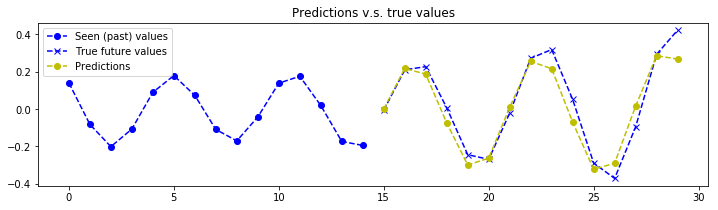

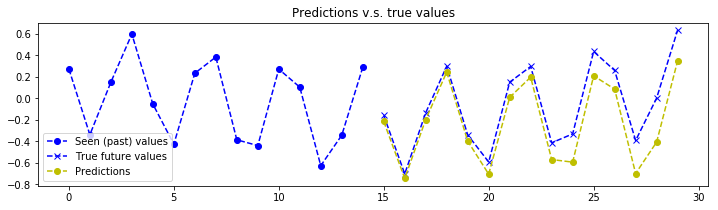

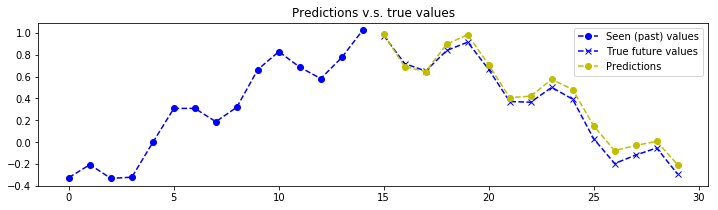

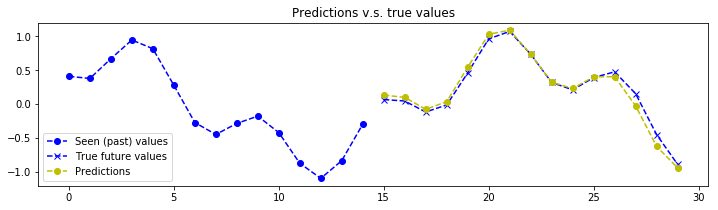

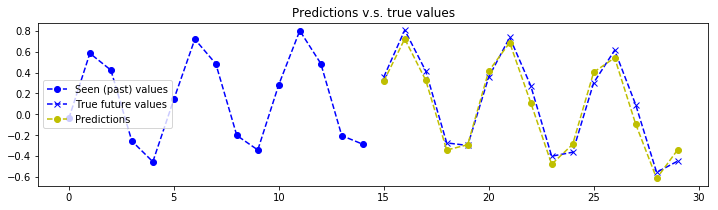

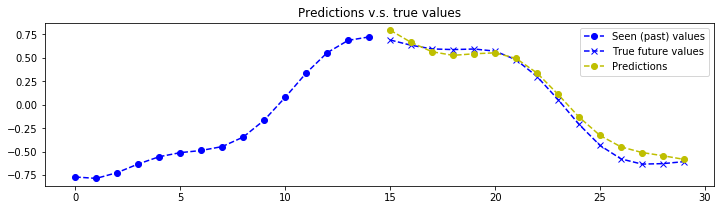

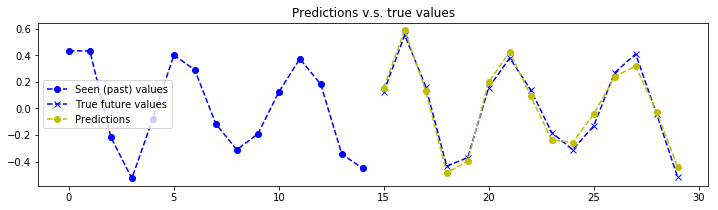

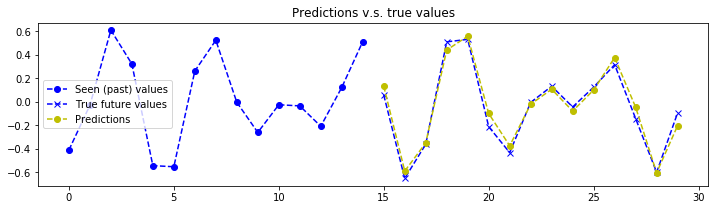

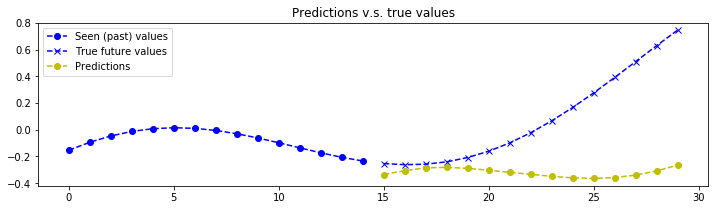

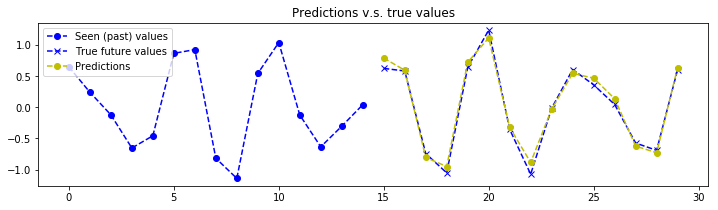

In [10]:
y_test_predicted = predict(x_test, encoder_predict_model, decoder_predict_model, target_sequence_length)
print(y_test_predicted.shape)

# Select 10 random examples to plot
indices = np.random.choice(range(x_test.shape[0]), replace=False, size=10)


for index in indices:
    plot_prediction(x_test[index, :, :], y_test[index, :, :], y_test_predicted[index, :, :])
    
# The model seems to struggle on very low wave signals. But that makes sense, the model doesn't see enough of the signal
# to make a good estimation of the frequency components.

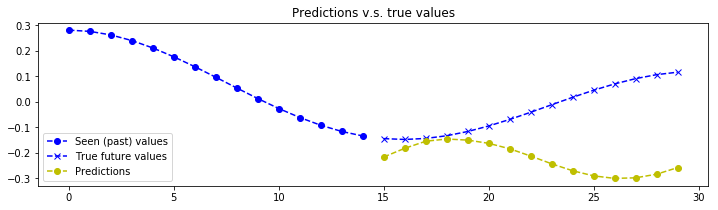

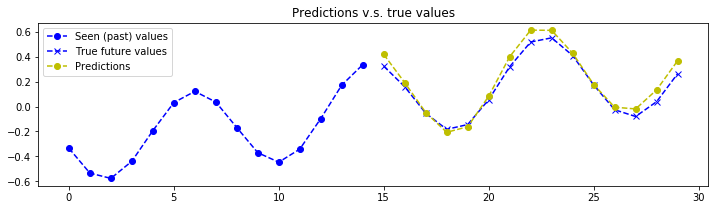

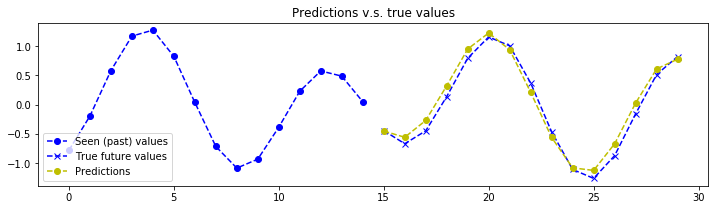

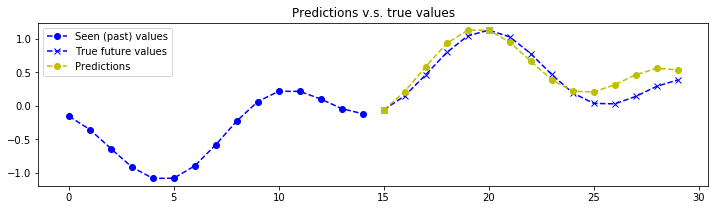

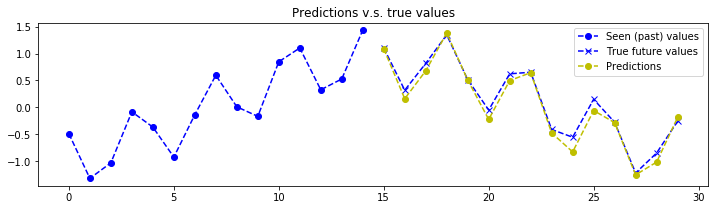

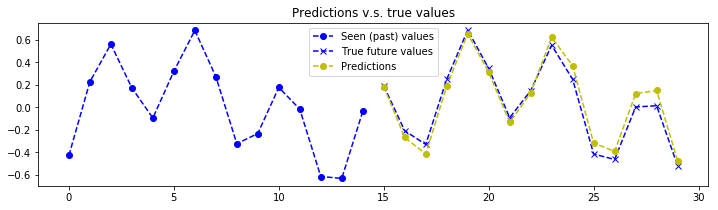

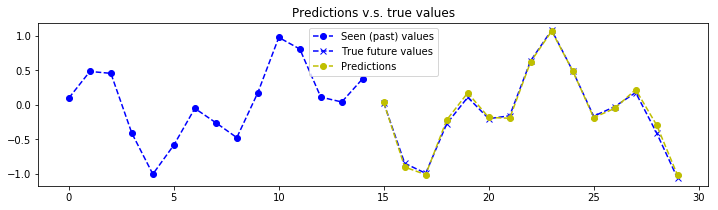

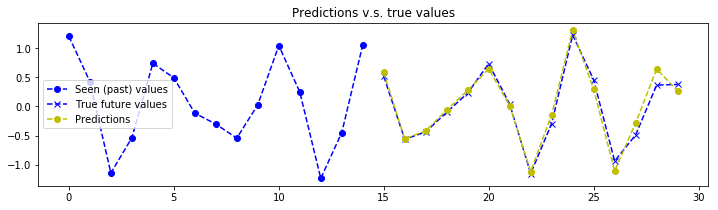

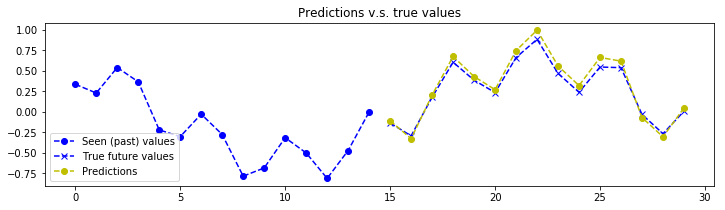

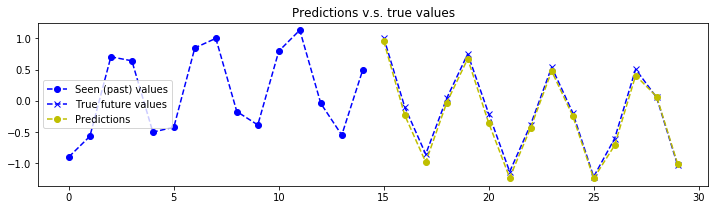

In [11]:
train_data_generator = random_sine(batch_size=1000,
                                  steps_per_epoch=steps_per_epoch,
                                  input_sequence_length=input_sequence_length,
                                  target_sequence_length=target_sequence_length,
                                  min_frequency=0.1, max_frequency=10,
                                  min_amplitude=0.1, max_amplitude=1,
                                  min_offset=-0.5, max_offset=0.5,
                                  num_signals=num_signals, seed=1969)

(x_train, _), y_train = next(train_data_generator)

y_train_predicted = predict(x_train, encoder_predict_model, decoder_predict_model, target_sequence_length)

# Select 10 random examples to plot
indices = np.random.choice(range(x_train.shape[0]), replace=False, size=10)

for index in indices:
    plot_prediction(x_train[index, :, :], y_train[index, :, :], y_train_predicted[index, :, :])

## Next steps

There are many things that could be done to either extend or improve this model. Here are a few ideas.

* There's no reason why the encoder and decoder should have the same complexity or the same number of layers. As well as doing a simple hyper parameter search, it could be interesting to implement a model with different encoder and decoder sizes. To do this, one would have to add a dense layer after retrieving the states of the encoder to transform them into the correct size.
* Encapsulate the encoder-decoder by creating a class with a fit/predict interface. This is actually something I have done, it's extremely useful as it allows to instantiate seq2seq models as easily as one would instantiate a scikit learn model.
* Add the ability to add context vectors to the state of output by the encoder. The encoder is able to produce an input vector for the decoder based on the time series. It is possible to add constant features to the model by duplicating them at each input timestep. However, adding the ability to extend the encoder output state with a constant vector that represents context might also be a good idea (for example, if you're predicting the evolution of housing prices, you might want to tell your model which geographical area you are in, since prices might not evolve in the same manner depending on location). This is not the attention mechanism often used in NLP that also produces what is called a context vector(a context vector that is updated at each step of the decoder). But since adding attention to NLP seq2seq applications has hugely improved state of the art. It might also be worth looking into attention for sequence prediction.

### Thanks for reading :)

I welcome questions or comments, you can find me on LinkedIn.

Author: Luke Tonin  
LinkedIn: https://fr.linkedin.com/in/luketonin  
Github: https://github.com/LukeTonin/  


In [2]:
# Let's convert this notebook to a README for the GitHub project's title page:

!jupyter nbconvert --to markdown keras-seq2seq-signal-prediction.ipynb
!mv keras-seq2seq-signal-prediction.md README.md

[NbConvertApp] Converting notebook keras-seq2seq-signal-prediction.ipynb to markdown
[NbConvertApp] Support files will be in keras-seq2seq-signal-prediction_files/
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_files
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_files
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_files
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_files
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_files
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_files
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_files
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_files
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_files
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_files
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_files
[NbConvertApp] Making directory keras-seq2seq-signal-prediction_fi